<a href="https://colab.research.google.com/github/solcanalla/fiumark/blob/main/xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modelo:XGBoost#

Ensamble de tipo boosting.

##Inicialización##


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

In [2]:
from sklearn.metrics import roc_curve, auc

def plot_roc(_fpr, _tpr, x):

    roc_auc = auc(_fpr, _tpr)

    plt.figure(figsize=(15, 10))
    plt.plot(
        _fpr, _tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})'
    )
    plt.scatter(_fpr, x)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [3]:
!git clone https://github.com/solcanalla/fiumark.git
%cd fiumark
!git pull origin main
import preprocessing as pp

Cloning into 'fiumark'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 147 (delta 79), reused 46 (delta 19), pack-reused 0
Receiving objects: 100% (147/147), 235.98 KiB | 1.27 MiB/s, done.
Resolving deltas: 100% (79/79), done.
/content/fiumark
From https://github.com/solcanalla/fiumark
 * branch            main       -> FETCH_HEAD
Already up to date.


##Pre procesamiento##

In [4]:
pd.options.display.max_columns = None
df = pp.get_dataset()
df = pp.knn_preprocessing(df)
X_train, X_test, y_train, y_test = pp.get_train_test_data(df)

##Entrenamiento##

In [5]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': np.arange(50,100,10),
    'max_depth': np.arange(1, 10),
    'min_child_weight': np.arange(1, 3)
}

clf = XGBClassifier()

gscv = GridSearchCV(
    clf, params, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

In [6]:
print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")

Best score: 0.864504017588048
Best params {'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 50}


##Evaluación del modelo##

In [7]:
y_pred = gscv.predict(X_test)

###Precision recall y F1-score###

In [8]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.93      0.86        95
         1.0       0.87      0.68      0.76        66

    accuracy                           0.83       161
   macro avg       0.84      0.80      0.81       161
weighted avg       0.83      0.83      0.82       161



###Accuracy###

In [9]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8260869565217391

###Auc-Roc###

In [10]:
from sklearn.metrics import roc_auc_score
auc_roc = roc_auc_score(y_test, y_pred)
auc_roc

0.8040669856459329

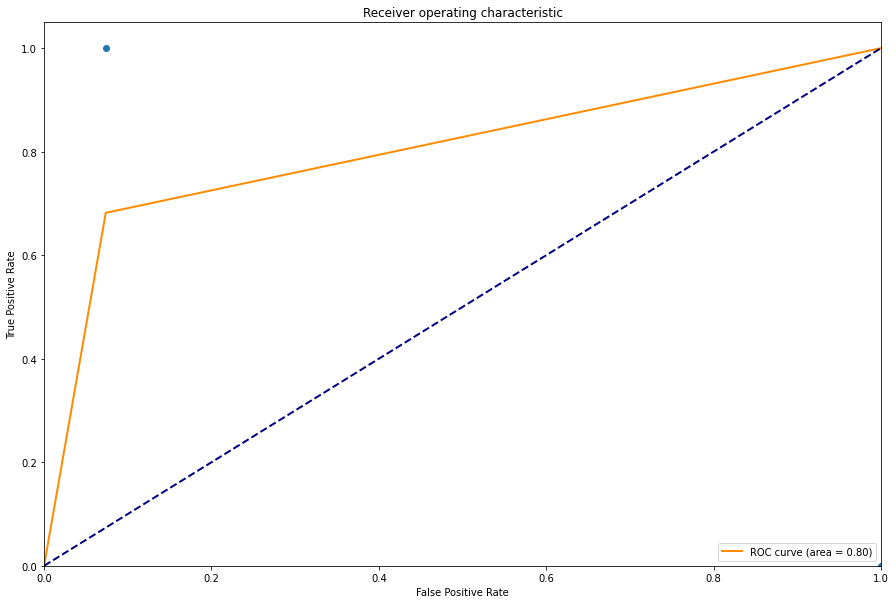

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plot_roc(fpr, tpr, thresholds)

###Matriz de confusión###

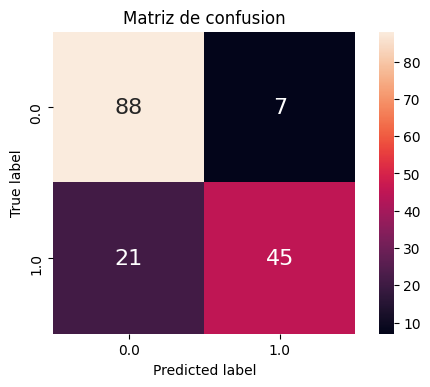

In [12]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusion")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


plot_confusion_matrix(y_test, y_pred)

##Predicción##

In [13]:
X_holdout = pd.read_csv('https://drive.google.com/uc?export=download&id=1I980-_K9iOucJO26SG5_M8RELOQ5VB6A')
X = pp.knn_preprocessing(X_holdout)
prediction = pd.DataFrame(gscv.predict(X),columns=['volveria'],dtype=int)
pred_formatted = pd.concat([X_holdout.id_usuario,prediction],axis=1)
pred_formatted.to_csv('xgboost.csv')
pred_formatted

,id_usuario,volveria
0,650,0
1,234,0
2,31,0
3,552,0
4,411,0
...,...,...
85,354,0
86,82,0
87,172,0
88,8,1
